## Santa 2020 replay visualizer

This notebook sets up an interactive plotly widget that can be used to visualise episodes. The widget shows:

- initial thresholds
- current thresholds
- current agent moves and whether they were successful
- cumulative agent rewards
- expected rewards (i.e. adding up the probabilities of success for each pull)
- cumulative agent pulls for each lever

The visualizer requires a running notebook to render each step. To use it, plug in an episode ID below, run all notebook cells, and then use the slider in the final cell to step through the episode.

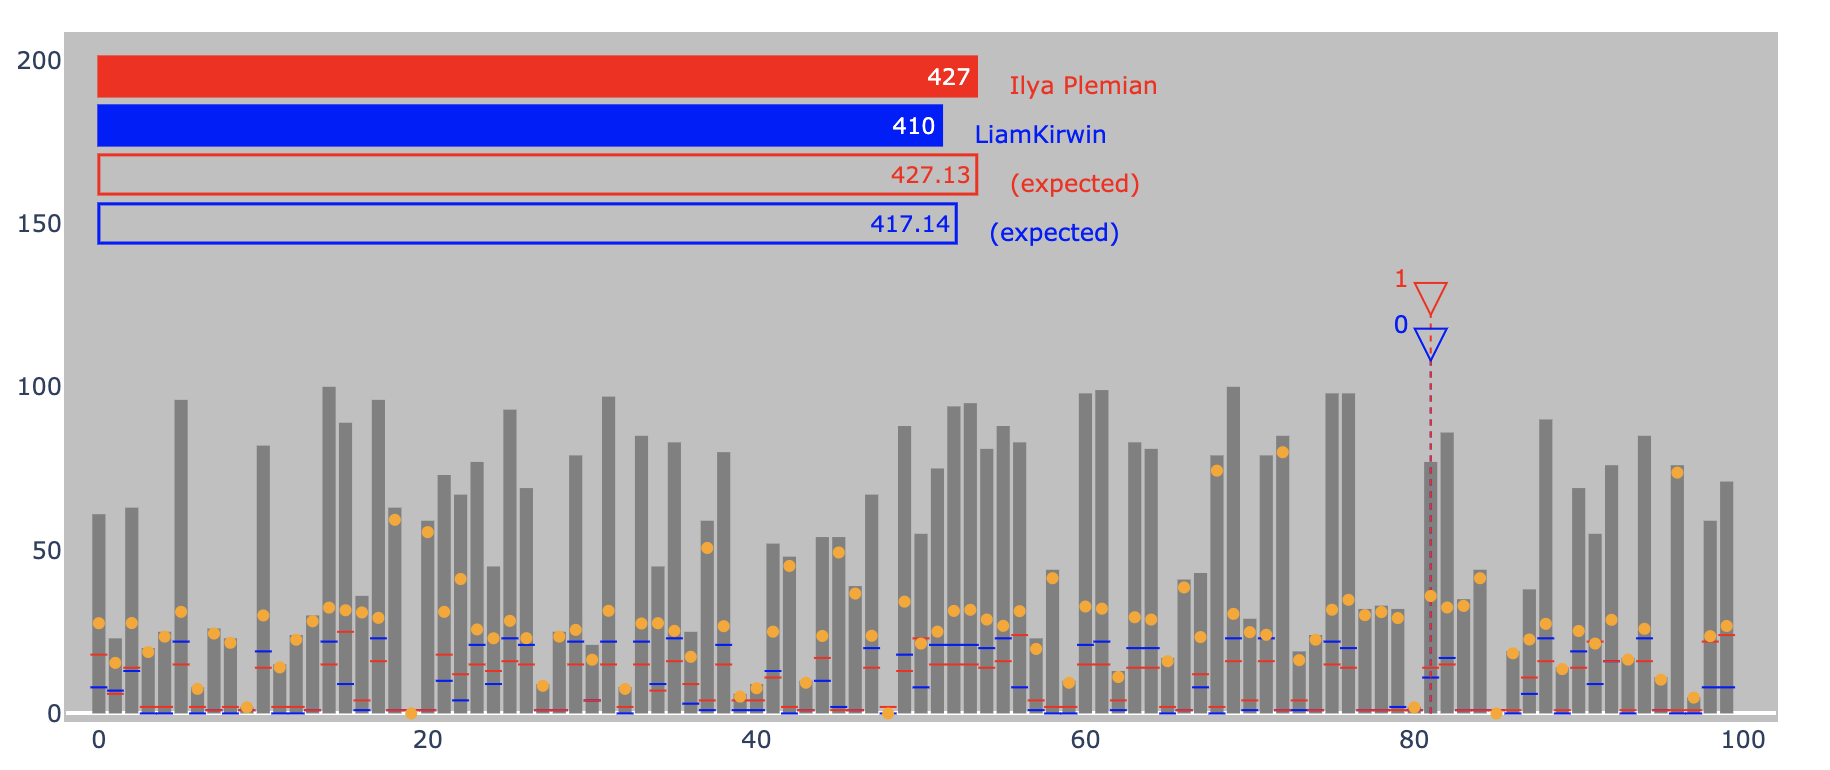

In [ ]:
import requests
import numpy as np
import plotly.graph_objects as go
from ipywidgets import interact

In [ ]:
EPISODE_ID = 7604169

url = f"https://www.kaggleusercontent.com/episodes/{EPISODE_ID}.json"
replay = requests.get(url).json()

In [ ]:
!pip install --upgrade kaggle_environments
import kaggle_environments

In [ ]:
env = kaggle_environments.make(
    "mab",
    configuration=replay["configuration"],
    steps=replay["steps"],
    info=replay["info"]
)

# # or instead of a replay you could simulate a new episode, e.g:
# env.run(["/kaggle/input/santa-2020/submission.py", "round_robin"])

print("rewards:", [agent.reward for agent in env.state])

In [ ]:
def make_traces(env, data, step):
    
    initial_thresholds = env.steps[0][0]["observation"]["thresholds"]
    current_thresholds = env.steps[step][0]["observation"]["thresholds"]
    actions = [s["action"] for s in env.steps[step]]
    rewards = [s["reward"] for s in env.steps[step]]

    if step > 0:
        last_rewards = [s["reward"] for s in env.steps[step - 1]]
    else:
        last_rewards = [0, 0]
        
    success = [1 if rewards[i] > last_rewards[i] else 0 for i in range(2)]
    
    text_offset = 5 if step < 85 else 2
    red = "red"
    blue = "blue"

    traces = [
        go.Scatter(
            name="agent0_pulls",
            x=list(range(100)),
            y=data["action_histogram"][0, step],
            mode="markers",
            marker=dict(symbol="line-ew", line=dict(width=1, color=blue)),
        ),
        go.Scatter(
            name="agent1_pulls",
            x=list(range(100)),
            y=data["action_histogram"][1, step],
            mode="markers",
            marker=dict(symbol="line-ew", line=dict(width=1, color=red)),
        ),
        go.Scatter(
            name="agent0_line",
            x=[actions[0]] * 2,
            y=[0, 108],
            mode="lines",
            line=dict(color=blue, dash="solid" if success[0] else "dot", width=1),
        ),
        go.Scatter(
            name="agent1_line",
            x=[actions[1]] * 2,
            y=[0, 122],
            mode="lines",
            line=dict(color=red, dash="solid" if success[1] else "dot", width=1),
        ),
        go.Scatter(
            name="agent_indicators",
            x=actions,
            y=[108, 122],
            text=["0", "1"],
            textposition="top left",
            textfont=dict(color=[blue, red]),
            mode="markers+text",
            marker=dict(
                color=[blue, red],
                size=16,
                symbol=["arrow-down" if s else "arrow-down-open" for s in success],
            ),
        ),
        go.Bar(
            name="initial_thresholds",
            x=list(range(100)),
            y=initial_thresholds,
            marker_line_width=0,
            marker_color="grey",
        ),
        go.Scatter(
            name="current_thresholds",
            x=list(range(100)),
            y=current_thresholds,
            mode="markers",
            marker_line_width=0,
            marker_color="orange"
        ),
        go.Bar(
            name="rewards",
            x=[r / 8 for r in rewards],
            y=[180, 195],
            text=rewards,
            textposition="auto",
            marker_line_width=1.5,
            marker_line_color=[blue, red],
            marker_color=[blue, red],
            orientation="h",
        ),
        go.Scatter(
            name="team_names",
            x=[r / 8 + text_offset for r in rewards],
            y=[180, 195],
            text=env.info.get("TeamNames", [""] * 2),
            textposition="bottom right",
            textfont=dict(color=[blue, red]),
            mode="text",
        ),
        go.Bar(
            name="expected_rewards",
            x=[r / 8 for r in data["expected_rewards"][:, step]],
            y=[150, 165],
            text=["{:.2f}".format(x) for x in data["expected_rewards"][:, step]],
            textposition="auto",
            textfont=dict(color=[blue, red]),
            marker_line_width=1.5,
            marker_line_color=[blue, red],
            marker_color="silver",
            orientation="h",
        ),
        go.Scatter(
            name="expected_label",
            x=[r / 8 + text_offset for r in data["expected_rewards"][:, step]],
            y=[150, 165],
            text="(expected)",
            textposition="bottom right",
            textfont=dict(color=[blue, red]),
            mode="text",
        ),
    ]
    
    return traces

In [ ]:
def make_figure_widget(env, n_traces=30):

    fig = go.FigureWidget()

    fig.update_xaxes(
        range=[-2, 102],
        zeroline=False,
        showgrid=False,
    )
    fig.update_yaxes(
        range=[-2, 208],
        zerolinecolor="white",
        showgrid=False,
    )
    fig.update_layout(
        showlegend=False,
        plot_bgcolor="silver",
        autosize=False,
        width=900,
        height=400,
        margin=dict(l=10, r=10, b=10, t=30, pad=1),
    )
    
    # create a couple extra datasets
    action_histogram = np.zeros((2, 2000, 100), dtype=int)
    expected_rewards = np.zeros((2, 2000), dtype=float)
    for step_idx, step in enumerate(env.steps):
        if step_idx == 0:
            continue
        for agent_idx, agent in enumerate(step):
            action = agent["action"]
            thresholds = env.steps[step_idx - 1][0]["observation"]["thresholds"]
            expected_reward = np.ceil(thresholds[action]) / 101
            action_histogram[agent_idx, step_idx:, action] += 1
            expected_rewards[agent_idx, step_idx:] += expected_reward
            
    data = {
        "action_histogram": action_histogram,
        "expected_rewards": expected_rewards,
    }

    fig.add_traces(make_traces(env, data, 0))

    return fig, data

In [ ]:
fig, data = make_figure_widget(env)

In [ ]:
@interact(step=(0, len(env.steps) - 1))
def interactive_display(step=0):
    fig.update(data=make_traces(env, data, step))
fig